In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn
import utils

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1763.11it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

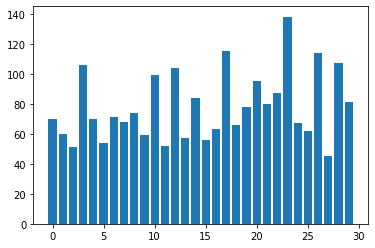

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

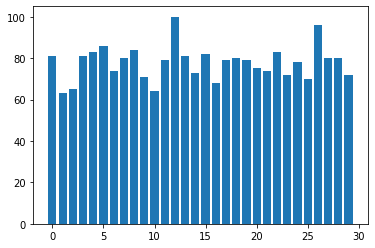

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [26]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [13]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=False
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [14]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [15]:
ConvLayer=Conv2D

In [22]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [23]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    ConvBlock(64,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(128,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(150,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(200,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 750, 64)       896       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 250, 128)       74368     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 125, 150)       173550    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 125, 200)       271000    
_________________________________________________________________
gba (GlobalAveragePooling2D) (None, 200)           

In [24]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [25]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
72/72 [==============================] - 11s 157ms/step - loss: 3.3971 - accuracy: 0.0720 - F1_0: 0.0000e+00 - F1_1: 0.0234 - F1_2: 0.0000e+00 - F1_3: 0.1173 - F1_4: 0.0918 - F1_5: 0.0384 - F1_6: 0.0430 - F1_7: 0.0718 - F1_8: 0.0060 - F1_9: 0.0426 - F1_10: 0.0174 - F1_11: 8.0580e-04 - F1_12: 0.0749 - F1_13: 0.0664 - F1_14: 0.0487 - F1_15: 0.0106 - F1_16: 0.0759 - F1_17: 0.0784 - F1_18: 0.0252 - F1_19: 0.0756 - F1_20: 0.0000e+00 - F1_21: 0.0072 - F1_22: 0.0668 - F1_23: 0.0972 - F1_24: 5.4795e-04 - F1_25: 0.0000e+00 - F1_26: 0.1411 - F1_27: 0.0000e+00 - F1_28: 0.1245 - F1_29: 0.0065 - val_loss: 4.2074 - val_accuracy: 0.0372 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1

72/72 [==============================] - 10s 145ms/step - loss: 2.1992 - accuracy: 0.3737 - F1_0: 0.2713 - F1_1: 0.0447 - F1_2: 0.0484 - F1_3: 0.3626 - F1_4: 0.3220 - F1_5: 0.0253 - F1_6: 0.1834 - F1_7: 0.5134 - F1_8: 0.4249 - F1_9: 0.4253 - F1_10: 0.3844 - F1_11: 0.1104 - F1_12: 0.4965 - F1_13: 0.1136 - F1_14: 0.2761 - F1_15: 0.3946 - F1_16: 0.3778 - F1_17: 0.3888 - F1_18: 0.3160 - F1_19: 0.2085 - F1_20: 0.4516 - F1_21: 0.3911 - F1_22: 0.2950 - F1_23: 0.3905 - F1_24: 0.1302 - F1_25: 0.3164 - F1_26: 0.5607 - F1_27: 0.0402 - F1_28: 0.4356 - F1_29: 0.2422 - val_loss: 3.4039 - val_accuracy: 0.1824 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.1765 - val_F1_3: 0.0000e+00 - val_F1_4: 0.1176 - val_F1_5: 0.1667 - val_F1_6: 0.3200 - val_F1_7: 0.0000e+00 - val_F1_8: 0.2330 - val_F1_9: 0.1167 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - val_F1_16: 0.3333 - val_F1_17: 0.0000e+00 - va

72/72 [==============================] - 11s 147ms/step - loss: 1.3393 - accuracy: 0.6332 - F1_0: 0.6053 - F1_1: 0.3584 - F1_2: 0.3489 - F1_3: 0.7251 - F1_4: 0.6759 - F1_5: 0.5869 - F1_6: 0.6297 - F1_7: 0.6594 - F1_8: 0.7245 - F1_9: 0.4454 - F1_10: 0.6029 - F1_11: 0.3666 - F1_12: 0.7645 - F1_13: 0.5581 - F1_14: 0.5284 - F1_15: 0.5784 - F1_16: 0.5743 - F1_17: 0.5888 - F1_18: 0.5432 - F1_19: 0.6281 - F1_20: 0.7580 - F1_21: 0.6675 - F1_22: 0.7338 - F1_23: 0.7139 - F1_24: 0.4891 - F1_25: 0.5630 - F1_26: 0.7008 - F1_27: 0.5270 - F1_28: 0.5263 - F1_29: 0.6661 - val_loss: 3.3491 - val_accuracy: 0.2308 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.1748 - val_F1_3: 0.0000e+00 - val_F1_4: 0.5161 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.2162 - val_F1_8: 0.1899 - val_F1_9: 0.1707 - val_F1_10: 0.0444 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0357 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3030 - val_F1_15: 0.0000e+00 - val_F1_16: 0.0000e+00 - val_F1_17: 0.2727 - val_F1_18:

Epoch 20/100
72/72 [==============================] - 11s 146ms/step - loss: 0.7875 - accuracy: 0.7843 - F1_0: 0.7883 - F1_1: 0.6429 - F1_2: 0.4935 - F1_3: 0.8150 - F1_4: 0.8514 - F1_5: 0.6760 - F1_6: 0.8463 - F1_7: 0.6675 - F1_8: 0.8134 - F1_9: 0.8763 - F1_10: 0.8530 - F1_11: 0.6410 - F1_12: 0.8417 - F1_13: 0.7146 - F1_14: 0.7899 - F1_15: 0.8451 - F1_16: 0.6789 - F1_17: 0.7558 - F1_18: 0.8521 - F1_19: 0.8091 - F1_20: 0.7874 - F1_21: 0.7831 - F1_22: 0.8184 - F1_23: 0.8408 - F1_24: 0.7701 - F1_25: 0.7197 - F1_26: 0.9023 - F1_27: 0.4926 - F1_28: 0.7463 - F1_29: 0.6880 - val_loss: 2.2125 - val_accuracy: 0.3983 - val_F1_0: 0.0923 - val_F1_1: 0.3256 - val_F1_2: 0.3711 - val_F1_3: 0.2667 - val_F1_4: 0.9032 - val_F1_5: 0.2424 - val_F1_6: 0.4000 - val_F1_7: 0.2745 - val_F1_8: 0.4956 - val_F1_9: 0.4651 - val_F1_10: 0.6571 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3333 - val_F1_13: 0.4444 - val_F1_14: 0.1887 - val_F1_15: 0.0556 - val_F1_16: 0.3000 - val_F1_17: 0.3333 - val_F1_18: 0.0000e+00 - val_F

Epoch 27/100
72/72 [==============================] - 11s 146ms/step - loss: 0.5420 - accuracy: 0.8533 - F1_0: 0.8189 - F1_1: 0.6131 - F1_2: 0.7810 - F1_3: 0.8518 - F1_4: 0.8328 - F1_5: 0.8096 - F1_6: 0.8265 - F1_7: 0.8204 - F1_8: 0.8436 - F1_9: 0.8862 - F1_10: 0.9155 - F1_11: 0.5885 - F1_12: 0.8853 - F1_13: 0.7352 - F1_14: 0.8401 - F1_15: 0.8615 - F1_16: 0.7662 - F1_17: 0.8228 - F1_18: 0.8460 - F1_19: 0.8620 - F1_20: 0.8576 - F1_21: 0.8507 - F1_22: 0.8165 - F1_23: 0.9294 - F1_24: 0.8690 - F1_25: 0.7839 - F1_26: 0.9285 - F1_27: 0.6308 - F1_28: 0.8980 - F1_29: 0.6962 - val_loss: 2.1347 - val_accuracy: 0.4243 - val_F1_0: 0.2941 - val_F1_1: 0.2105 - val_F1_2: 0.3248 - val_F1_3: 0.6977 - val_F1_4: 0.8235 - val_F1_5: 0.1379 - val_F1_6: 0.1895 - val_F1_7: 0.4000 - val_F1_8: 0.4789 - val_F1_9: 0.4138 - val_F1_10: 0.7632 - val_F1_11: 0.2105 - val_F1_12: 0.0000e+00 - val_F1_13: 0.4615 - val_F1_14: 0.4225 - val_F1_15: 0.2051 - val_F1_16: 0.1905 - val_F1_17: 0.4103 - val_F1_18: 0.2353 - val_F1_19

Epoch 34/100
72/72 [==============================] - 10s 146ms/step - loss: 0.4038 - accuracy: 0.8976 - F1_0: 0.9053 - F1_1: 0.7103 - F1_2: 0.7406 - F1_3: 0.8916 - F1_4: 0.9194 - F1_5: 0.8947 - F1_6: 0.8767 - F1_7: 0.8408 - F1_8: 0.8630 - F1_9: 0.8881 - F1_10: 0.9355 - F1_11: 0.7557 - F1_12: 0.8982 - F1_13: 0.9166 - F1_14: 0.9324 - F1_15: 0.8994 - F1_16: 0.8885 - F1_17: 0.8679 - F1_18: 0.8930 - F1_19: 0.9117 - F1_20: 0.9085 - F1_21: 0.8561 - F1_22: 0.9496 - F1_23: 0.9058 - F1_24: 0.8867 - F1_25: 0.9434 - F1_26: 0.9233 - F1_27: 0.7799 - F1_28: 0.8584 - F1_29: 0.8536 - val_loss: 1.9602 - val_accuracy: 0.4702 - val_F1_0: 0.3182 - val_F1_1: 0.0714 - val_F1_2: 0.5957 - val_F1_3: 0.5000 - val_F1_4: 0.4706 - val_F1_5: 0.4898 - val_F1_6: 0.3462 - val_F1_7: 0.5238 - val_F1_8: 0.3509 - val_F1_9: 0.3077 - val_F1_10: 0.8090 - val_F1_11: 0.1695 - val_F1_12: 0.2400 - val_F1_13: 0.5556 - val_F1_14: 0.1633 - val_F1_15: 0.5417 - val_F1_16: 0.2500 - val_F1_17: 0.5200 - val_F1_18: 0.0645 - val_F1_19: 0.

Epoch 41/100
72/72 [==============================] - 11s 147ms/step - loss: 0.3192 - accuracy: 0.9158 - F1_0: 0.8911 - F1_1: 0.7881 - F1_2: 0.8487 - F1_3: 0.9203 - F1_4: 0.9013 - F1_5: 0.8981 - F1_6: 0.9312 - F1_7: 0.8855 - F1_8: 0.8737 - F1_9: 0.9237 - F1_10: 0.9546 - F1_11: 0.8488 - F1_12: 0.9038 - F1_13: 0.8378 - F1_14: 0.9208 - F1_15: 0.9189 - F1_16: 0.8653 - F1_17: 0.9431 - F1_18: 0.9029 - F1_19: 0.8922 - F1_20: 0.9104 - F1_21: 0.8798 - F1_22: 0.9224 - F1_23: 0.9483 - F1_24: 0.9052 - F1_25: 0.9343 - F1_26: 0.8639 - F1_27: 0.7097 - F1_28: 0.9289 - F1_29: 0.9208 - val_loss: 1.8501 - val_accuracy: 0.4814 - val_F1_0: 0.3333 - val_F1_1: 0.3810 - val_F1_2: 0.2692 - val_F1_3: 0.5909 - val_F1_4: 0.7442 - val_F1_5: 0.4651 - val_F1_6: 0.3462 - val_F1_7: 0.5000 - val_F1_8: 0.4516 - val_F1_9: 0.5814 - val_F1_10: 0.8354 - val_F1_11: 0.2182 - val_F1_12: 0.2500 - val_F1_13: 0.5882 - val_F1_14: 0.3636 - val_F1_15: 0.4000 - val_F1_16: 0.2154 - val_F1_17: 0.5614 - val_F1_18: 0.4444 - val_F1_19: 0.

Epoch 48/100
72/72 [==============================] - 11s 146ms/step - loss: 0.2603 - accuracy: 0.9345 - F1_0: 0.8626 - F1_1: 0.8420 - F1_2: 0.8286 - F1_3: 0.8871 - F1_4: 0.9586 - F1_5: 0.9153 - F1_6: 0.9718 - F1_7: 0.9305 - F1_8: 0.9750 - F1_9: 0.8758 - F1_10: 0.9234 - F1_11: 0.8454 - F1_12: 0.9656 - F1_13: 0.8990 - F1_14: 0.9178 - F1_15: 0.9538 - F1_16: 0.8799 - F1_17: 0.9474 - F1_18: 0.9217 - F1_19: 0.9177 - F1_20: 0.9250 - F1_21: 0.9012 - F1_22: 0.9082 - F1_23: 0.9568 - F1_24: 0.9266 - F1_25: 0.9539 - F1_26: 0.9556 - F1_27: 0.8274 - F1_28: 0.9055 - F1_29: 0.9032 - val_loss: 2.0354 - val_accuracy: 0.5037 - val_F1_0: 0.3448 - val_F1_1: 0.2703 - val_F1_2: 0.2041 - val_F1_3: 0.6818 - val_F1_4: 0.9697 - val_F1_5: 0.1481 - val_F1_6: 0.3030 - val_F1_7: 0.4898 - val_F1_8: 0.4062 - val_F1_9: 0.5556 - val_F1_10: 0.8235 - val_F1_11: 0.2609 - val_F1_12: 0.3750 - val_F1_13: 0.6667 - val_F1_14: 0.5067 - val_F1_15: 0.4211 - val_F1_16: 0.2333 - val_F1_17: 0.5600 - val_F1_18: 0.1905 - val_F1_19: 0.

Epoch 55/100
72/72 [==============================] - 10s 145ms/step - loss: 0.2179 - accuracy: 0.9436 - F1_0: 0.9492 - F1_1: 0.8944 - F1_2: 0.8579 - F1_3: 0.9658 - F1_4: 0.9424 - F1_5: 0.9505 - F1_6: 0.9246 - F1_7: 0.9624 - F1_8: 0.9253 - F1_9: 0.9738 - F1_10: 0.9749 - F1_11: 0.9244 - F1_12: 0.9888 - F1_13: 0.9434 - F1_14: 0.9504 - F1_15: 0.9953 - F1_16: 0.9166 - F1_17: 0.9388 - F1_18: 0.9108 - F1_19: 0.9326 - F1_20: 0.9529 - F1_21: 0.9900 - F1_22: 0.9483 - F1_23: 0.9595 - F1_24: 0.9231 - F1_25: 0.9324 - F1_26: 0.9554 - F1_27: 0.9429 - F1_28: 0.9556 - F1_29: 0.9323 - val_loss: 2.0814 - val_accuracy: 0.4926 - val_F1_0: 0.1304 - val_F1_1: 0.3902 - val_F1_2: 0.6462 - val_F1_3: 0.7500 - val_F1_4: 0.5818 - val_F1_5: 0.5909 - val_F1_6: 0.3902 - val_F1_7: 0.3582 - val_F1_8: 0.4561 - val_F1_9: 0.6207 - val_F1_10: 0.7397 - val_F1_11: 0.3111 - val_F1_12: 0.2034 - val_F1_13: 0.4545 - val_F1_14: 0.2800 - val_F1_15: 0.3273 - val_F1_16: 0.6087 - val_F1_17: 0.3636 - val_F1_18: 0.6364 - val_F1_19: 0.

Epoch 62/100
72/72 [==============================] - 10s 146ms/step - loss: 0.1992 - accuracy: 0.9510 - F1_0: 0.9541 - F1_1: 0.8436 - F1_2: 0.8310 - F1_3: 0.9931 - F1_4: 0.9004 - F1_5: 0.9844 - F1_6: 0.9583 - F1_7: 0.9381 - F1_8: 0.9656 - F1_9: 0.9473 - F1_10: 0.9741 - F1_11: 0.8668 - F1_12: 0.9698 - F1_13: 0.9817 - F1_14: 0.9298 - F1_15: 0.9645 - F1_16: 0.9594 - F1_17: 0.9591 - F1_18: 0.9568 - F1_19: 0.9495 - F1_20: 0.9651 - F1_21: 0.9821 - F1_22: 0.9254 - F1_23: 0.9461 - F1_24: 0.9316 - F1_25: 0.9737 - F1_26: 0.9856 - F1_27: 0.8694 - F1_28: 0.9708 - F1_29: 0.9507 - val_loss: 2.3921 - val_accuracy: 0.4367 - val_F1_0: 0.0000e+00 - val_F1_1: 0.3077 - val_F1_2: 0.3077 - val_F1_3: 0.6047 - val_F1_4: 0.8889 - val_F1_5: 0.2759 - val_F1_6: 0.3333 - val_F1_7: 0.2778 - val_F1_8: 0.5070 - val_F1_9: 0.5000 - val_F1_10: 0.8250 - val_F1_11: 0.0000e+00 - val_F1_12: 0.2192 - val_F1_13: 0.5714 - val_F1_14: 0.3467 - val_F1_15: 0.1395 - val_F1_16: 0.2857 - val_F1_17: 0.5000 - val_F1_18: 0.0000e+00 - v

Epoch 69/100
72/72 [==============================] - 10s 146ms/step - loss: 0.1667 - accuracy: 0.9614 - F1_0: 0.9642 - F1_1: 0.9547 - F1_2: 0.8687 - F1_3: 0.9886 - F1_4: 0.8883 - F1_5: 0.9741 - F1_6: 0.9236 - F1_7: 0.9616 - F1_8: 0.9834 - F1_9: 0.9978 - F1_10: 0.9652 - F1_11: 0.9078 - F1_12: 0.9485 - F1_13: 0.9938 - F1_14: 0.9481 - F1_15: 0.9911 - F1_16: 0.9548 - F1_17: 0.9973 - F1_18: 0.9565 - F1_19: 0.9252 - F1_20: 0.9600 - F1_21: 0.9745 - F1_22: 0.9184 - F1_23: 0.9760 - F1_24: 0.9496 - F1_25: 0.9380 - F1_26: 0.9851 - F1_27: 0.9269 - F1_28: 0.9656 - F1_29: 0.9726 - val_loss: 1.9374 - val_accuracy: 0.5285 - val_F1_0: 0.3125 - val_F1_1: 0.5769 - val_F1_2: 0.4898 - val_F1_3: 0.6500 - val_F1_4: 0.7895 - val_F1_5: 0.3684 - val_F1_6: 0.4186 - val_F1_7: 0.4691 - val_F1_8: 0.4400 - val_F1_9: 0.6286 - val_F1_10: 0.7551 - val_F1_11: 0.4375 - val_F1_12: 0.3846 - val_F1_13: 0.4000 - val_F1_14: 0.1333 - val_F1_15: 0.4800 - val_F1_16: 0.3750 - val_F1_17: 0.5366 - val_F1_18: 0.5600 - val_F1_19: 0.

Epoch 76/100
72/72 [==============================] - 11s 147ms/step - loss: 0.1586 - accuracy: 0.9583 - F1_0: 0.9332 - F1_1: 0.8877 - F1_2: 0.9270 - F1_3: 0.9523 - F1_4: 0.9468 - F1_5: 0.9287 - F1_6: 0.9883 - F1_7: 0.9503 - F1_8: 0.9828 - F1_9: 0.9597 - F1_10: 0.9785 - F1_11: 0.9346 - F1_12: 0.9759 - F1_13: 0.9600 - F1_14: 0.9462 - F1_15: 0.9649 - F1_16: 0.9531 - F1_17: 0.9902 - F1_18: 0.9537 - F1_19: 0.9452 - F1_20: 0.9364 - F1_21: 0.9628 - F1_22: 0.9656 - F1_23: 0.9716 - F1_24: 0.9555 - F1_25: 0.9487 - F1_26: 0.9697 - F1_27: 0.9301 - F1_28: 0.9591 - F1_29: 0.9425 - val_loss: 1.7086 - val_accuracy: 0.5658 - val_F1_0: 0.1053 - val_F1_1: 0.5098 - val_F1_2: 0.5507 - val_F1_3: 0.7755 - val_F1_4: 0.9375 - val_F1_5: 0.6250 - val_F1_6: 0.3902 - val_F1_7: 0.5455 - val_F1_8: 0.6000 - val_F1_9: 0.7297 - val_F1_10: 0.8158 - val_F1_11: 0.5161 - val_F1_12: 0.4516 - val_F1_13: 0.6250 - val_F1_14: 0.4262 - val_F1_15: 0.4667 - val_F1_16: 0.4286 - val_F1_17: 0.6061 - val_F1_18: 0.2326 - val_F1_19: 0.

Epoch 83/100
72/72 [==============================] - 10s 146ms/step - loss: 0.1520 - accuracy: 0.9575 - F1_0: 0.9291 - F1_1: 0.9156 - F1_2: 0.8491 - F1_3: 0.9763 - F1_4: 0.9688 - F1_5: 0.9373 - F1_6: 0.9583 - F1_7: 0.9414 - F1_8: 0.9794 - F1_9: 0.8830 - F1_10: 0.9421 - F1_11: 0.9686 - F1_12: 0.9806 - F1_13: 0.9973 - F1_14: 0.9577 - F1_15: 0.9738 - F1_16: 0.9335 - F1_17: 0.9603 - F1_18: 0.8974 - F1_19: 0.9421 - F1_20: 0.9624 - F1_21: 0.9735 - F1_22: 0.9135 - F1_23: 0.9737 - F1_24: 0.8862 - F1_25: 0.8756 - F1_26: 0.9294 - F1_27: 0.9425 - F1_28: 0.9191 - F1_29: 0.9486 - val_loss: 2.0252 - val_accuracy: 0.5409 - val_F1_0: 0.3385 - val_F1_1: 0.5600 - val_F1_2: 0.7200 - val_F1_3: 0.5143 - val_F1_4: 0.3556 - val_F1_5: 0.5862 - val_F1_6: 0.5116 - val_F1_7: 0.2857 - val_F1_8: 0.3111 - val_F1_9: 0.7000 - val_F1_10: 0.8810 - val_F1_11: 0.3077 - val_F1_12: 0.2667 - val_F1_13: 0.4211 - val_F1_14: 0.2857 - val_F1_15: 0.5385 - val_F1_16: 0.2222 - val_F1_17: 0.5429 - val_F1_18: 0.4000 - val_F1_19: 0.

Epoch 90/100
72/72 [==============================] - 11s 146ms/step - loss: 0.1284 - accuracy: 0.9627 - F1_0: 0.9822 - F1_1: 0.9256 - F1_2: 0.9641 - F1_3: 0.9709 - F1_4: 0.9348 - F1_5: 0.9897 - F1_6: 0.9943 - F1_7: 0.9832 - F1_8: 0.9632 - F1_9: 0.9462 - F1_10: 1.0000 - F1_11: 0.9426 - F1_12: 0.9851 - F1_13: 0.9540 - F1_14: 0.9679 - F1_15: 0.9793 - F1_16: 0.9277 - F1_17: 0.9680 - F1_18: 0.9539 - F1_19: 0.9534 - F1_20: 0.9837 - F1_21: 0.8663 - F1_22: 0.9380 - F1_23: 0.9972 - F1_24: 0.8516 - F1_25: 0.9305 - F1_26: 0.9232 - F1_27: 0.8277 - F1_28: 0.9562 - F1_29: 0.9398 - val_loss: 2.3729 - val_accuracy: 0.5012 - val_F1_0: 0.4762 - val_F1_1: 0.1714 - val_F1_2: 0.3896 - val_F1_3: 0.5789 - val_F1_4: 0.7778 - val_F1_5: 0.6190 - val_F1_6: 0.3333 - val_F1_7: 0.3492 - val_F1_8: 0.3636 - val_F1_9: 0.6377 - val_F1_10: 0.7356 - val_F1_11: 0.4000 - val_F1_12: 0.6000 - val_F1_13: 0.4211 - val_F1_14: 0.2642 - val_F1_15: 0.5862 - val_F1_16: 0.1961 - val_F1_17: 0.3750 - val_F1_18: 0.4242 - val_F1_19: 0.

Epoch 97/100
72/72 [==============================] - 11s 146ms/step - loss: 0.1158 - accuracy: 0.9709 - F1_0: 0.9739 - F1_1: 0.9067 - F1_2: 0.9058 - F1_3: 0.9755 - F1_4: 0.8564 - F1_5: 0.9122 - F1_6: 0.9411 - F1_7: 0.9442 - F1_8: 0.9836 - F1_9: 0.9487 - F1_10: 0.9798 - F1_11: 0.9826 - F1_12: 0.9706 - F1_13: 0.9938 - F1_14: 0.9127 - F1_15: 1.0000 - F1_16: 0.9816 - F1_17: 0.9536 - F1_18: 0.9713 - F1_19: 0.9649 - F1_20: 0.9953 - F1_21: 0.9854 - F1_22: 0.9563 - F1_23: 0.9778 - F1_24: 0.9707 - F1_25: 0.9626 - F1_26: 0.9870 - F1_27: 0.9844 - F1_28: 0.9788 - F1_29: 0.9845 - val_loss: 2.4668 - val_accuracy: 0.4926 - val_F1_0: 0.3243 - val_F1_1: 0.3415 - val_F1_2: 0.4340 - val_F1_3: 0.4706 - val_F1_4: 0.8125 - val_F1_5: 0.3125 - val_F1_6: 0.4444 - val_F1_7: 0.5091 - val_F1_8: 0.4082 - val_F1_9: 0.6486 - val_F1_10: 0.8182 - val_F1_11: 0.5000 - val_F1_12: 0.3636 - val_F1_13: 0.5556 - val_F1_14: 0.0000e+00 - val_F1_15: 0.3111 - val_F1_16: 0.2857 - val_F1_17: 0.6977 - val_F1_18: 0.6957 - val_F1_19

In [27]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'unaugmented_2.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [29]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [30]:
training_history_file

'training_history/unaugmented_2.json'

In [31]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [32]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [33]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

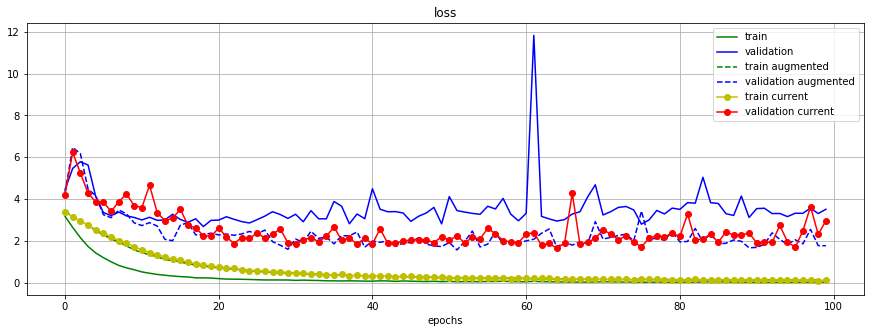

In [34]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

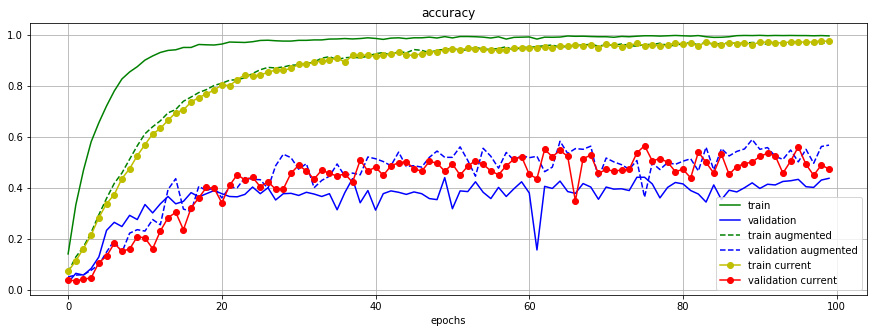

In [35]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

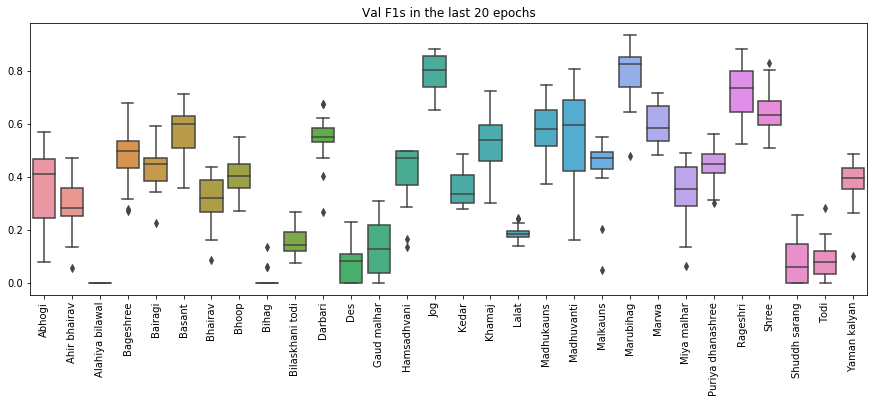

In [36]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

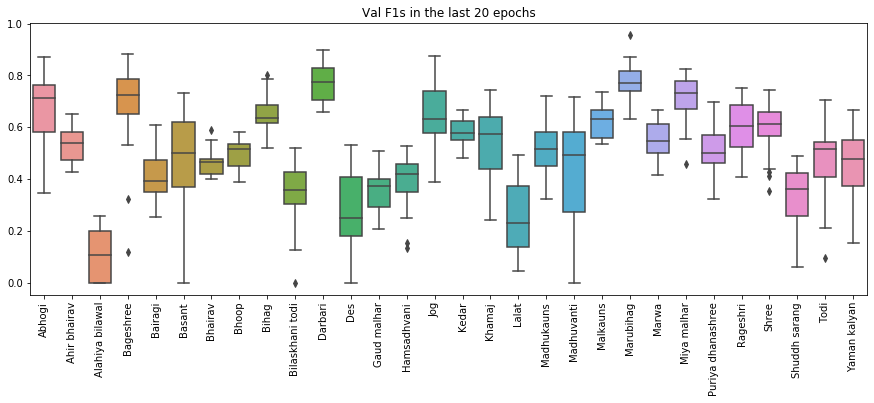

In [37]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

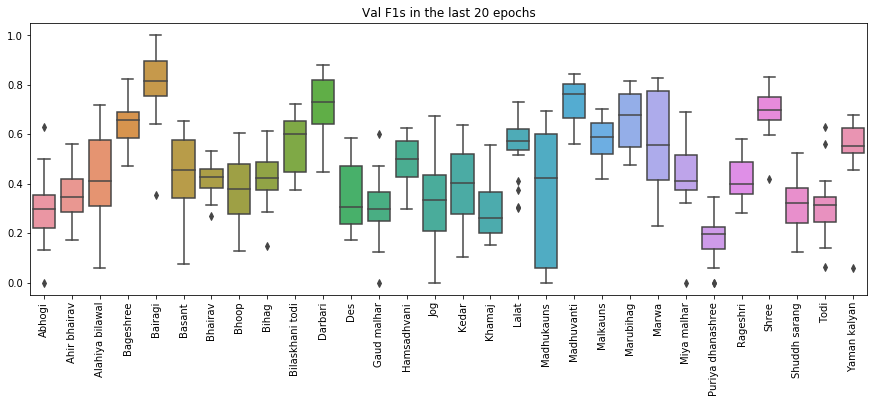

In [38]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

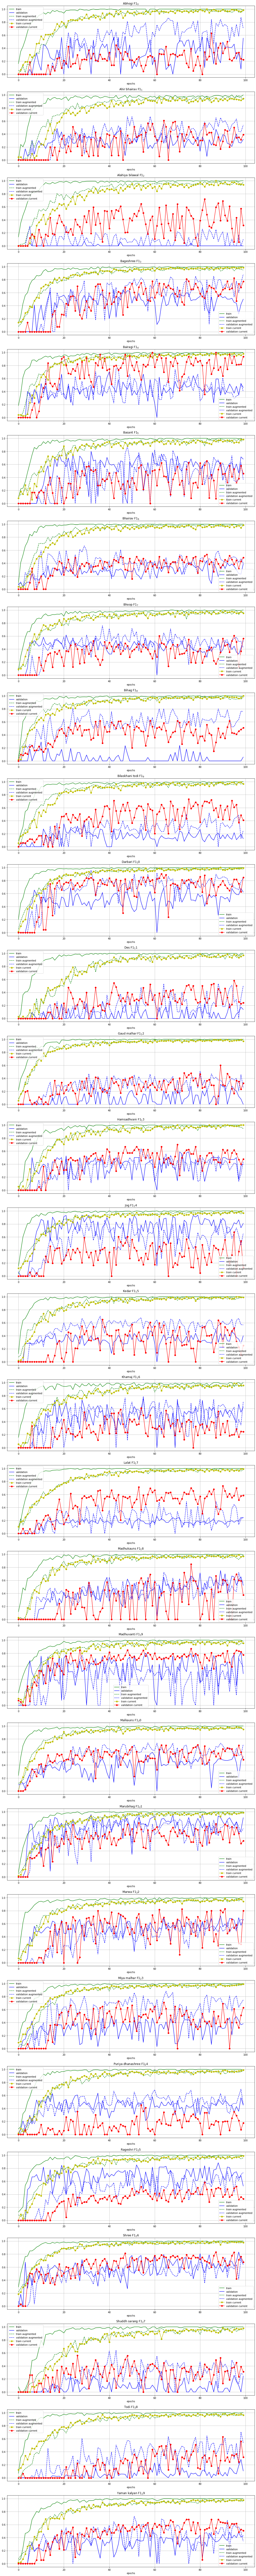

In [39]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(True)
plt.tight_layout()

In [40]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [41]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


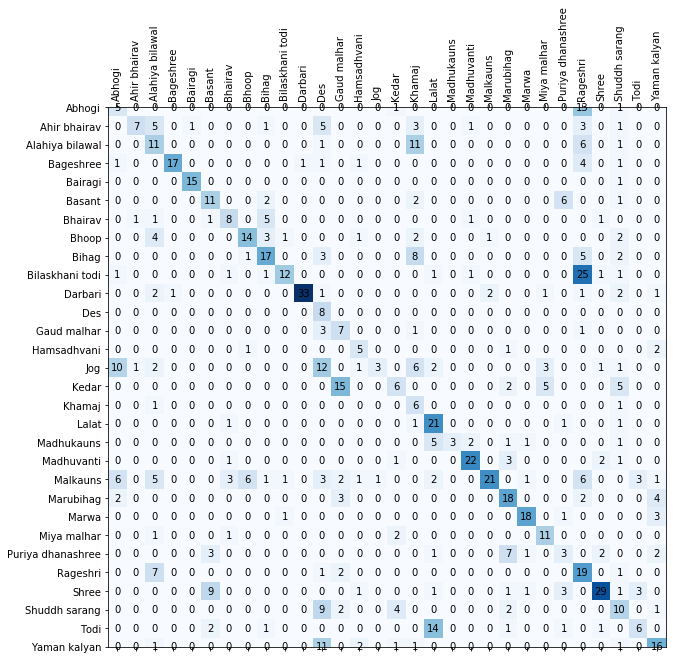

In [42]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [43]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [44]:
precision,recall,f1=process_confusion_matrix(cm)

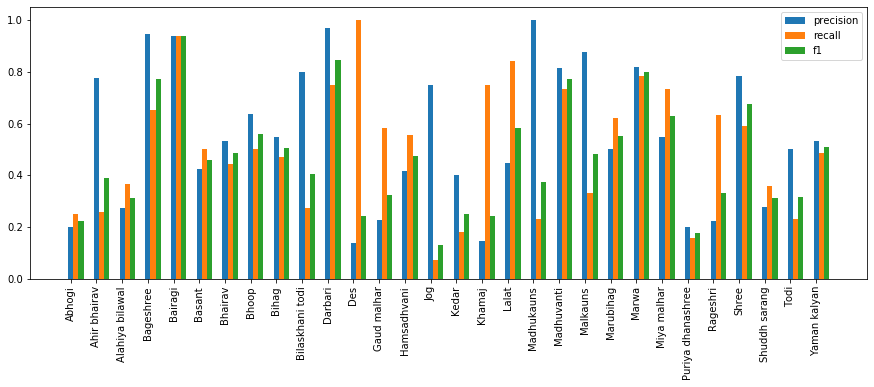

In [45]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()